In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm

In [2]:
# Create translationally-invariant `kwant.Builder`
bulk_graphene, syst_V = kwant_examples.graphene_extended_hubbard()

In [3]:
# Extract hopping vectors from dummy interacting system
hopping_vecs = utils.extract_hopping_vectors(syst_V)
hopping_vecs = np.unique(np.stack([*hopping_vecs, *-hopping_vecs]), axis=(0))

In [4]:
# Use wraparound to make infinite system
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene).finalized()
wrapped_V = kwant.wraparound.wraparound(syst_V).finalized()

In [5]:
# Compute non-interacting Hamiltonian on a coarse k-point grid
# Number of k-points along each direction
nk = 15
# k-points must start at zero
ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)
hamiltonians_0 = utils.syst2hamiltonian(ks, wrapped_syst)

In [6]:
def compute_gap(
    H_int,
    ks,
    ks_dense,
    hamiltonians_0=hamiltonians_0,
    filling=2,
    tol=1e-5,
    mixing=0.01,
    order=10,
    guess=None
):
    # Generate guess on the same grid
    if guess is None:
        guess = utils.generate_guess(ks, hopping_vecs, ndof=hamiltonians_0.shape[-1], scale=1)
    else:
        guess += np.max(guess) * utils.generate_guess(ks, hopping_vecs, ndof=hamiltonians_0.shape[-1], scale=0.1)

    # Find groundstate Hamiltonian on the same grid
    hk = hf.find_groundstate_ham(
        H_int=H_int,
        filling=filling,
        hamiltonians_0=hamiltonians_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Compute groundstate Hamiltonian on a dense grid
    scf_ham = utils.hk_densegrid(hk, ks, ks_dense, hopping_vecs)
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(scf_ham)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)
    return gap, hk - hamiltonians_0

In [7]:
def compute_phase_diagram(Us, Vs, ks, ks_dense, tol, mixing, order):
    Uk = utils.syst2hamiltonian(ks, wrapped_V, params=dict(U=1, V=0))
    Vk = utils.syst2hamiltonian(ks, wrapped_V, params=dict(U=0, V=1))
    gap = []
    for U in tqdm(Us):
        guess = None
        gap_U = []
        for V in Vs:
            H_int = U * Uk + V * Vk
            _gap, guess = compute_gap(
                H_int=H_int,
                ks=ks,
                ks_dense=ks_dense,
                tol=tol,
                mixing=mixing,
                order=order,
                guess=guess,
            )
            gap_U.append(_gap)
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

In [ ]:
# Generate dense-grid k-points
nk_dense = 30
ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
# Interaction strengths
Us = np.linspace(0, 4, 10, endpoint=True)
Vs = np.linspace(0, 1.5, 10, endpoint=True)
gap = compute_phase_diagram(Us, Vs, ks=ks, ks_dense=ks_dense, tol=1e-4, mixing=0.01, order=10)

  0%|          | 0/10 [00:00<?, ?it/s]

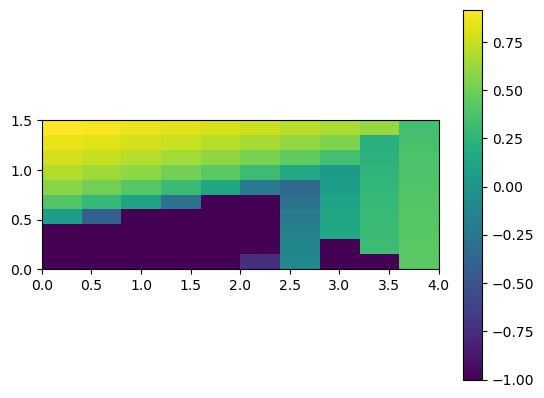

In [11]:
plt.imshow(np.log10(gap).T, origin='lower', extent=(Us.min(), Us.max(), Vs.min(), Vs.max()), vmin=-1)
plt.colorbar()

In [17]:
import xarray as xr
gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))

In [18]:
gap_da.to_netcdf('./data/graphene_example.nc')